In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from collections import Counter
import pandas_profiling

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

df = pd.read_csv('stud_math.csv')
stud = df.copy()

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска. Посмотреть на распределение признака для числовых переменных, устранить выбросы.Оценить количество уникальных значений для номинативных переменных. Провести корреляционный анализ количественных переменных, отобрать не коррелирующие переменные. Проанализировать номинативные переменные и устранить те, которые не влияют на предсказываемую величину score. Сформулировать выводы относительно качества данных и тех переменных, которые будем использовать в дальнейшем построении модели.

Посмотрим на наш датасет

In [81]:
display(stud.head(10))
stud.info() 

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Сразу можно сказать, что в данных есть некорректные значения, например, столбец famrel, в котором должны быть значения от 1 до 5. Есть пропуски. Посмотрим много ли их.

<AxesSubplot:>

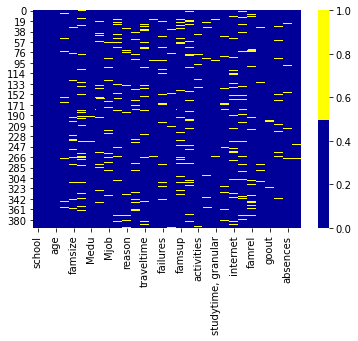

In [82]:
# тепловая карта пропущенных значений
cols = stud.columns[:30] # первые 30 колонок
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(stud[cols].isnull(), cmap=sns.color_palette(colours))

Оценим численное значение пропущенных данных.

In [83]:
def missing_values_table(df):
        # Всего отсутствующих значений
        mis_val = df.isnull().sum()
        
        # Процент пропущенных значений
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Составим таблицу с результатами
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Переименуем столбцы
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Пропуски', 1 : '% пропусков'})
        
       # Отсортируем таблицу по проценту пропущенных по убыванию
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% пропусков', ascending=False).round(1)
        
        # Выведем таблицу на экран
        print ("В нашем датафрейме " + str(df.shape[1]) + " столбцов.\n"      
            "В " + str(mis_val_table_ren_columns.shape[0]) +
              " колонках есть пропущенные данные.")
        
        # Вернуть фрейм данных с отсутствующей информацией
        return mis_val_table_ren_columns

In [84]:
missing_values_table(stud)

В нашем датафрейме 30 столбцов.
В 27 колонках есть пропущенные данные.


,Пропуски,% пропусков
Pstatus,45,11.4
paid,40,10.1
famsup,39,9.9
Fjob,36,9.1
internet,34,8.6
romantic,31,7.8
guardian,31,7.8
traveltime,28,7.1
famrel,27,6.8
famsize,27,6.8


In [85]:
# отберем числовые колонки
stud_numeric = stud.select_dtypes(include=[np.number])
numeric_cols = stud_numeric.columns.values
print(numeric_cols)

['age' 'Medu' 'Fedu' 'traveltime' 'studytime' 'failures'
 'studytime, granular' 'famrel' 'freetime' 'goout' 'health' 'absences'
 'score']


В нашем датафрейме 13 числовых колонок, из них 3 точно числовые, остальные - категориальные.

In [86]:
# отберем нечисловые колонки
stud_non_numeric = stud.select_dtypes(exclude=[np.number])
non_numeric_cols = stud_non_numeric.columns.values
print(non_numeric_cols)

['school' 'sex' 'address' 'famsize' 'Pstatus' 'Mjob' 'Fjob' 'reason'
 'guardian' 'schoolsup' 'famsup' 'paid' 'activities' 'nursery' 'higher'
 'internet' 'romantic']


Сразу посмотрим на столбец Score, так как именно это будет учиться предсказывать будущая модель.

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

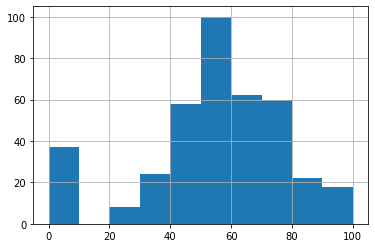

In [87]:
stud.score.hist()
stud.score.describe()

Мы видим, что баллы за экзамен в основном распределены в диапозоне от 20 до 100. Как мы увидели ранее в этом столбце есть 6 пропущенных значений. Заполнить пропуски на данный момент не представляется возможным и их лучше удалить.

In [88]:
stud.dropna(subset=['score'], inplace=True)

In [89]:
display(pd.DataFrame(stud.score.value_counts().sort_values()))
display(stud.score.count())

,score
100.0,1
20.0,1
95.0,5
85.0,6
25.0,7
35.0,9
90.0,12
30.0,15
80.0,16
70.0,27


389

Пустых значений нет, нулевые значения пока удалять не будем, по условию оценки находятся в интервале от 0 до 100 баллов. Нужны дополнительные сведения, чтобы понять почему 37 человек получили 0 баллов за экзамен - не пришли, ничего не написали, решили все неправильно, болели.

**ABSENCES**  
Количество пропущенных занятий

count    378.000000
mean       7.320106
std       23.615525
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

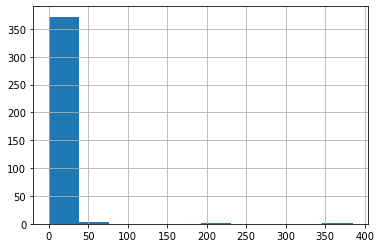

In [90]:
stud.absences.hist()
stud.absences.describe()

Данные в основном расположены в диапозоне от 0 до 70-80. Как мы видим в данных есть выбросы, посмотрим что это за данные.

In [91]:
display(stud[stud['absences'] >= 80]['absences'])

222    385.0
390    212.0
Name: absences, dtype: float64

Есть два нетипичных значения - 212 и 385, скорее всего ошибка ввода информации, заменим их на наиболее вероятные значения. Значения в диапозоне - 50-75 - уже не такие критичные, если допустить в среднем 6 занятий в день - приблизительно 2 недели, возможно пропуски по болезни.

In [92]:
def replacement(x):
    
    if x == 212:
        x = 21
    elif x == 385:    
        x =  38
    else:
        x = x
    return x


stud.absences = stud.absences.apply(replacement)

<AxesSubplot:>

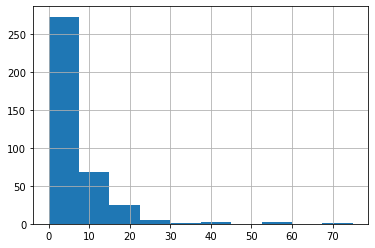

In [93]:
# Посмотрим график после удаления нетипичных значений
stud.absences.hist()

**AGE**  
Возраст ученика (от 15 до 22 лет)

count    389.000000
mean      16.673522
std        1.265662
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

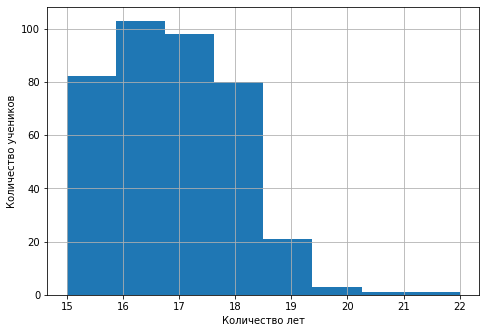

In [94]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(stud['age'], bins = 8)
axes.set_ylabel('Количество учеников')
axes.set_xlabel('Количество лет')
axes.grid(axis = 'both')
stud.age.describe()

Как мы видим пропусков в столбце нет, распределение несимметричное, смещенное вправо. Так как по условию возраст учеников находится в диапозоне от 15 до 22 лет, будем считать, что выбросов нет.*

**MEDU**  
Образование матери  
(0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [95]:
display(pd.DataFrame(stud.Medu.value_counts()))
display(stud.Medu.count())

,Medu
4.0,131
2.0,100
3.0,96
1.0,56
0.0,3


386

В столбце есть пропущенные значения, нетипичных значений нет. Пропущенные данные можно заменить медианным значением, сделаем это чуть позже.

Посмотрим на распределение данных.

4.0    131
2.0    100
3.0     96
1.0     56
0.0      3
Name: Medu, dtype: int64

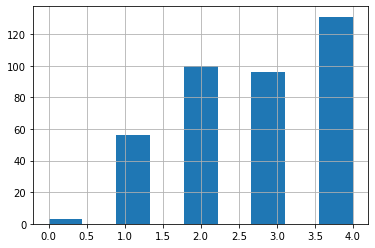

In [96]:
stud.Medu.hist(bins = 9, grid = True)
stud.Medu.value_counts()

**FEDU**  
Образование отца  
(0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [97]:
display(pd.DataFrame(stud.Fedu.value_counts()))
display(stud.Fedu.count())

,Fedu
2.0,105
3.0,94
4.0,88
1.0,75
0.0,2
40.0,1


365

В столбце есть пропуски и нетипичное значение 40, скорее всего это ошибка ввода и надо заменить его. 

In [98]:
stud.Fedu = stud.Fedu.apply(lambda x: 4 if x == 40 else x)

Посмотрим на то как распределены данные.

2.0    105
3.0     94
4.0     89
1.0     75
0.0      2
Name: Fedu, dtype: int64

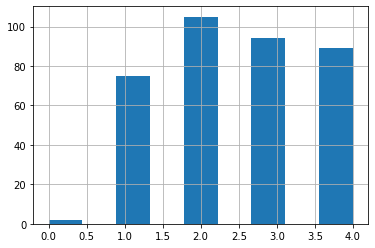

In [99]:
stud.Fedu.hist(bins = 9, grid = True)
stud.Fedu.value_counts()

Распределение столбцов очень похожи, можно посмотреть на корреляцию между ними.

In [100]:
stud['Medu'].corr(stud['Fedu'])

0.6219813871588825

Значения в этих столбцах скоррелированы и можно попробовать осуществить замену пропущенных значений в столбце Fedu значениями из столбца Medu. Для уменьшения размерности таблицы можно попробовать создать один признак из этих двух столбцов.

**TRAVELTIME**  
Время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

In [101]:
display(pd.DataFrame(stud.traveltime.value_counts()))
display(stud.traveltime.count())

,traveltime
1.0,239
2.0,94
3.0,21
4.0,7


361

В столбце есть пропущенные значения, нетипичных значений нет. Посмотрим на распределение.

1.0    239
2.0     94
3.0     21
4.0      7
Name: traveltime, dtype: int64

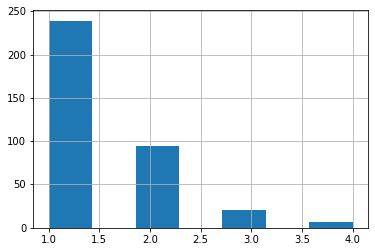

In [102]:
stud.traveltime.hist(bins = 7, grid = True)
stud.traveltime.value_counts()

По нашему графику видно, что большинство учеников живут в шаговой доступности от школы.

**STUDYTIME**  
Время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

In [103]:
display(pd.DataFrame(stud.studytime.value_counts()))
display(stud.studytime.count())

,studytime
2.0,189
1.0,103
3.0,63
4.0,27


382

В столбце есть пропущенные значения, не очень много, нетипичных значений нет.

2.0    189
1.0    103
3.0     63
4.0     27
Name: studytime, dtype: int64

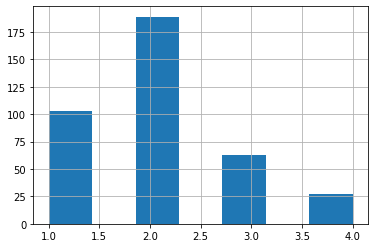

In [104]:
stud.studytime.hist(bins = 7, grid = True)
stud.studytime.value_counts()

**FAILURES**  
Количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

In [105]:
display(pd.DataFrame(stud.failures.value_counts()))
display(stud.failures.count())

,failures
0.0,290
1.0,48
2.0,15
3.0,14


367

В столбце есть пропущенные значения, нетипичных значений нет.

2.0    189
1.0    103
3.0     63
4.0     27
Name: studytime, dtype: int64

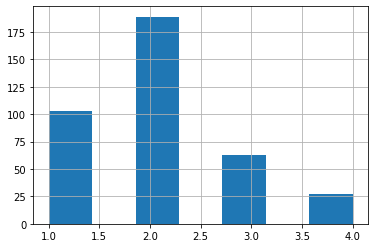

In [106]:
stud.studytime.hist(bins = 7, grid = True)
stud.studytime.value_counts()

Непонятно, какие неудачи случались с учениками вне школы и с чем они связаны. Для данного фактора не хватает исходных данных. Посмотрим на корреляцию с целевой переменной.

In [107]:
stud['failures'].corr(stud['score'])

-0.3443382999897429

Отрицательная корреляция говорит нам о том, что чем ниже показатель failures тем выше показатель score.

**STUDYTIME, GRANULAR**

Вообще непонятно, что за столбец и что он означает. Отложим его на время.

**FAMREL**  
Cемейные отношения (от 1 - очень плохо до 5 - очень хорошо)

In [108]:
display(pd.DataFrame(stud.famrel.value_counts()))
display(stud.famrel.count())

,famrel
4.0,178
5.0,97
3.0,62
2.0,17
1.0,7
-1.0,1


362

Есть пропуски. Есть нетипичные значения, заменим их.

In [109]:
stud.famrel = stud.famrel.apply(lambda x: 1 if x == -1 else x)

4.0    178
5.0     97
3.0     62
2.0     17
1.0      8
Name: famrel, dtype: int64

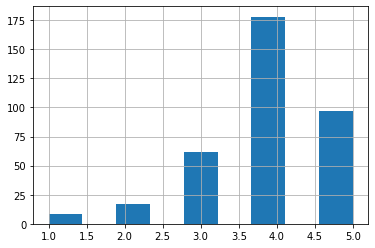

In [110]:
stud.famrel.hist(bins = 9, grid = True)
stud.famrel.value_counts()

Из гистограммы видно, что наши школьники живут в относительно благоприятных семьях.

**FREETIME**  
Cвободное время после школы (от 1 - очень мало до 5 - очень мого)

In [111]:
display(pd.DataFrame(stud.freetime.value_counts()))
display(stud.freetime.count())

,freetime
3.0,152
4.0,110
2.0,63
5.0,37
1.0,18


380

В столбце есть пропущенные значения, нетипичных значений нет.

3.0    152
4.0    110
2.0     63
5.0     37
1.0     18
Name: freetime, dtype: int64

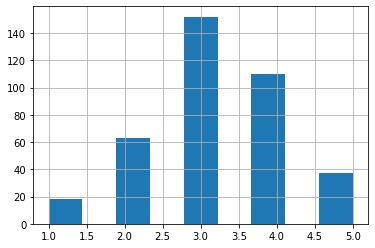

In [112]:
stud.freetime.hist(bins = 9, grid = True)
stud.freetime.value_counts()

**GOOUT**  
Проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

In [113]:
display(pd.DataFrame(stud.goout.value_counts()))
display(stud.goout.count())

,goout
3.0,126
2.0,101
4.0,81
5.0,51
1.0,23


382

Есть пропущенные значения, нетипичных значений нет.

3.0    126
2.0    101
4.0     81
5.0     51
1.0     23
Name: goout, dtype: int64

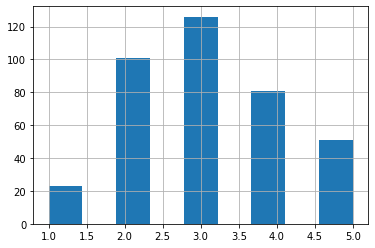

In [114]:
stud.goout.hist(bins = 9, grid = True)
stud.goout.value_counts()

По гистограмме видно, что основную массу составляют вполне обычные дети.

**HEALTH**  
Текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

In [115]:
display(pd.DataFrame(stud.health.value_counts()))
display(stud.health.count())

,health
5.0,137
3.0,88
4.0,60
1.0,47
2.0,42


374

Есть пропущенные значения, нетипичных значений нет.

5.0    137
3.0     88
4.0     60
1.0     47
2.0     42
Name: health, dtype: int64

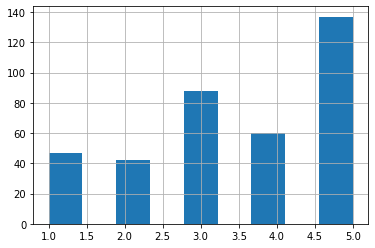

In [116]:
stud.health.hist(bins = 9, grid = True)
stud.health.value_counts()

Для нашей выборки достаточно большое количество детей со слабым здоровьем.

Построим тепловую карту корреляций, чтобы оценить взаимосвязь числовых данных датафрейма.

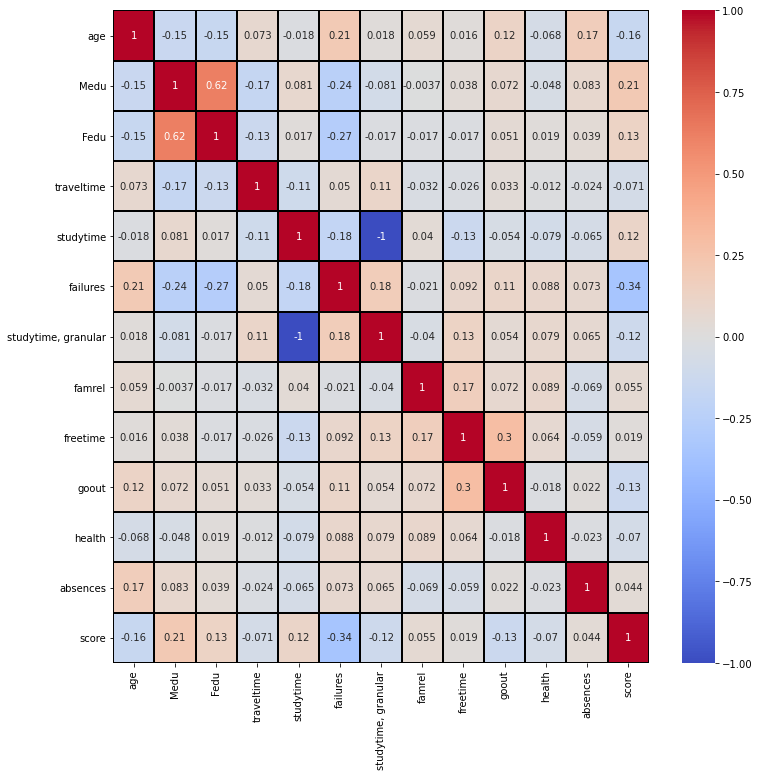

In [117]:
sns.heatmap(stud.corr(),annot = True, cmap = 'coolwarm', linewidths=1, linecolor='black')
fig = plt.gcf()
fig.set_size_inches(12,12)

На тепловой карте видно, что есть полностью скоррелированные признаки - studytime и stadytime, granular. Мы можем удалить один из столбцов, избавимся от stadytime, granular - так как изначально не понятно что там за данные.  


In [118]:
stud.drop(['studytime, granular'], inplace = True, axis = 1)

Также есть достаточная корреляция между столбцами Medu и Fedu, можно попробовать сделать из них какой-то новый признак и заодно сократить размерность нашей таблицы.  
Есть отрицательная корреляция между нашим целевым признаком и famrel, которая показывает что чем лучше отношения в семье, тем лучше успеваемость по математике.  
Остальные значения мало скоррелированы с нашим целевым признаком.   
Признаки в столбцах traveltime, studytime, failures, famrel, freetime, goout, health с малым количеством уникальных значений можно закодировать бинарно.

Попробуем заменить пропуски в наших столбцах  и посмотреть насколько это окажет влияние на уровень корреляции.

In [119]:
stud_numeric_new = stud.select_dtypes(include=[np.number]).copy()
for col in stud_numeric_new:
    stud[col].fillna(stud[col].ffill(), inplace=True)

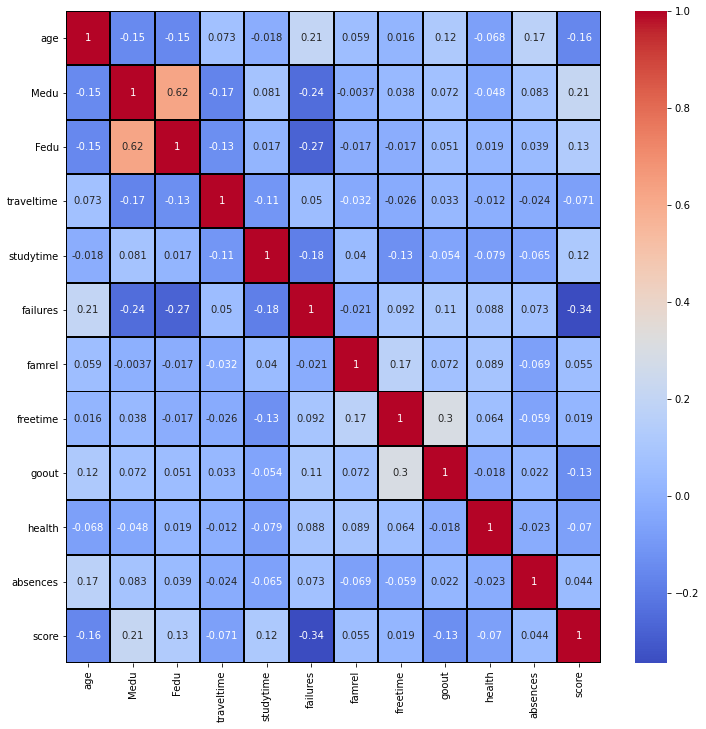

In [120]:
sns.heatmap(stud_numeric_new.corr(),annot = True, cmap = 'coolwarm',
            linewidths=1, linecolor='black')
fig = plt.gcf()
fig.set_size_inches(12,12)

При замене пропущенных значений ближайшими значениями матрица корреляций изменилась не кардинально и в принципе такая замена может быть использована, за неимением на данном этапе других методов вменения пропусков.

**Теперь проанализируем номинативные переменные.**

**SCHOOL**  
Аббревиатура школы, в которой учится ученик

In [121]:
display(pd.DataFrame(stud.school.value_counts()))
display(stud.school.count())

,school
GP,344
MS,45


389

В нашем столбце нет пропусков и всего два уникальных значения.

**SEX**  
Пол ученика ('F' - женский, 'M' - мужской)

In [122]:
display(pd.DataFrame(stud.sex.value_counts()))
display(stud.sex.count())

,sex
F,204
M,185


389

В данном столбце нет пропущенных и нетипичных значений.

**ADDRESS**  
Тип адреса ученика ('U' - городской, 'R' - за городом)

In [123]:
display(pd.DataFrame(stud.address.value_counts()))
display(stud.address.count())

,address
U,291
R,83


374

Значения столбца принимают всего два значения, как и сказано в описании датасета. 
Есть пропущенные значения, их не так много. Можно заменить их случайным образом, 
исходя из соотношения заполненых значений. И применить данную стратегию для всех пропусков в категориальных данных

**FAMSIZE**  
Размер семьи ('LE3' <= 3, 'GT3' >3)

In [124]:
display(pd.DataFrame(stud.famsize.value_counts()))
display(stud.famsize.count())

,famsize
GT3,255
LE3,107


362

Нетипичных значений нет, зато есть пропуски.

**PSTATUS**  
Статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

In [125]:
display(pd.DataFrame(stud.Pstatus.value_counts()))
display(stud.Pstatus.count())

,Pstatus
T,308
A,36


344

Нетипичных значений нет, количество пропусков - 45.

**MJOB**  
Работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [126]:
display(pd.DataFrame(stud.Mjob.value_counts()))
display(stud.Mjob.count())

,Mjob
other,127
services,98
at_home,58
teacher,55
health,32


370

Пропущенных значений - 19, нетипичных значений нет.

**FJOB**  
Работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [127]:
display(pd.DataFrame(stud.Fjob.value_counts()))
display(stud.Fjob.count())

,Fjob
other,194
services,99
teacher,29
at_home,16
health,15


353

Пропущенных значений - 36, нетипичных значений нет.

**REASON**  
Причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

In [128]:
display(pd.DataFrame(stud.reason.value_counts()))
display(stud.reason.count())

,reason
course,135
reputation,102
home,101
other,34


372

Пропущенных значений - 17, нетипичных значений нет.

**GUARDIAN**  
Опекун ('mother' - мать, 'father' - отец, 'other' - другое)

In [129]:
display(pd.DataFrame(stud.guardian.value_counts()))
display(stud.guardian.count())

,guardian
mother,248
father,86
other,24


358

Пропущенных значений - 31, нетипичных значений нет.

**SCHOOLSUP**  
Дополнительная образовательная поддержка (yes или no)

In [130]:
display(pd.DataFrame(stud.schoolsup.value_counts()))
display(stud.schoolsup.count())

,schoolsup
no,331
yes,49


380

Пропусков не так много и значений подстановки тоже, можно заменить случайным образом.

**FAMSUP**  
Семейная образовательная поддержка (yes или no)

In [131]:
display(pd.DataFrame(stud.famsup.value_counts()))
display(stud.famsup.count())

,famsup
yes,216
no,135


351

Пропущенных значений - 38, нетипичных значений нет.

**PAID**  
Дополнительные платные занятия по математике (yes или no)

In [132]:
display(pd.DataFrame(stud.paid.value_counts()))
display(stud.paid.count())

,paid
no,197
yes,153


350

Пропущенных значений - 39, нетипичных значений нет.

**ACTIVITIES**  
Дополнительные внеучебные занятия (yes или no)

In [133]:
display(pd.DataFrame(stud.activities.value_counts()))
display(stud.activities.count())

,activities
yes,192
no,183


375

Пропущенных значений - 14, нетипичных значений нет.

**NURSERY**  
Посещал детский сад (yes или no)

In [134]:
display(pd.DataFrame(stud.nursery.value_counts()))
display(stud.nursery.count())

,nursery
yes,297
no,77


374

Пропущенных значений - 15, нетипичных значений нет.

**HIGHER**  
Хочет получить высшее образование (yes или no)

In [135]:
display(pd.DataFrame(stud.higher.value_counts()))
display(stud.higher.count())

,higher
yes,350
no,19


369

Пропущенных значений - 20, нетипичных значений нет.

**INTERNET**  
Наличие интернета дома (yes или no)

In [136]:
display(pd.DataFrame(stud.internet.value_counts()))
display(stud.internet.count())

,internet
yes,300
no,55


355

Пропущенных значений - 34, нетипичных значений нет.

**ROMANTIC**  
В романтических отношениях (yes или no)

In [137]:
display(pd.DataFrame(stud.romantic.value_counts()))
display(stud.romantic.count())

,romantic
no,235
yes,123


358

Пропущенных значений - 31, нетипичных значений нет.

Посмотрим, различаются ли распределения оценки в зависимости от значения номинативных переменных с помощью box-plot. 

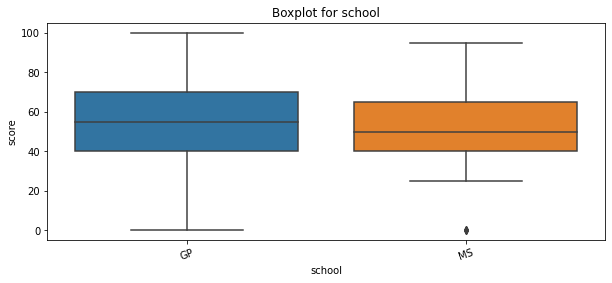

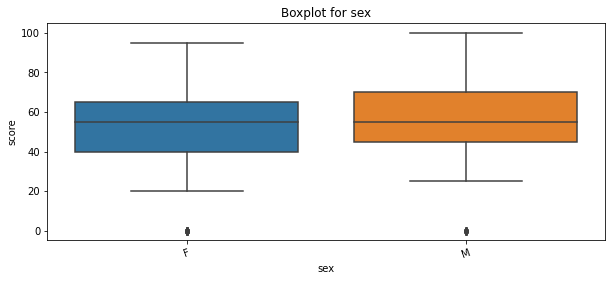

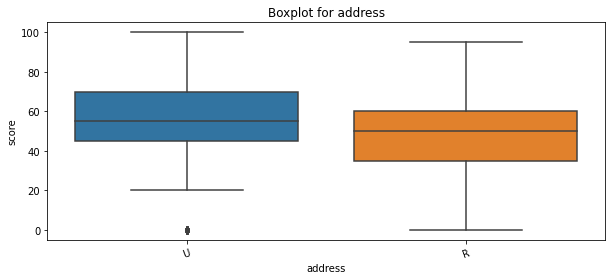

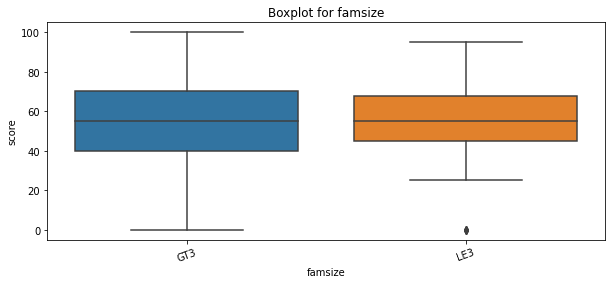

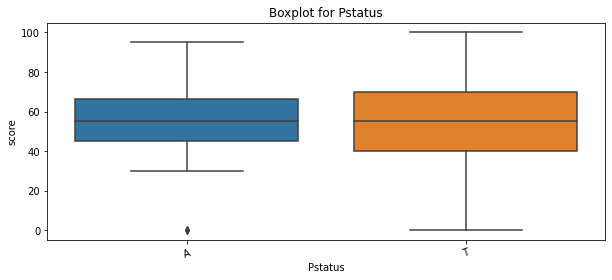

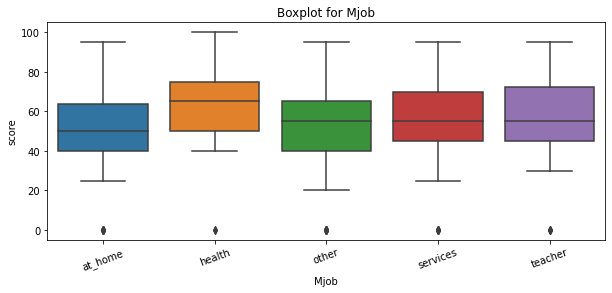

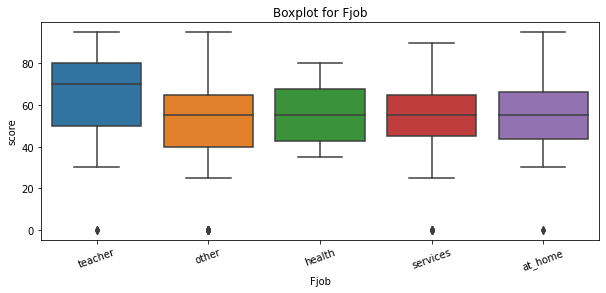

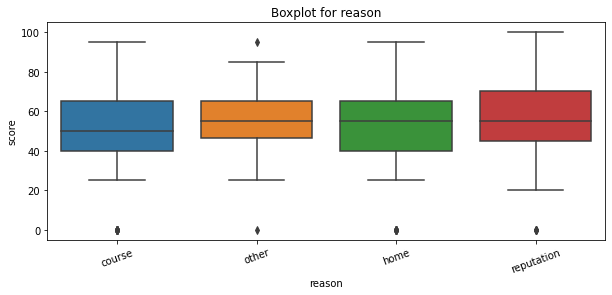

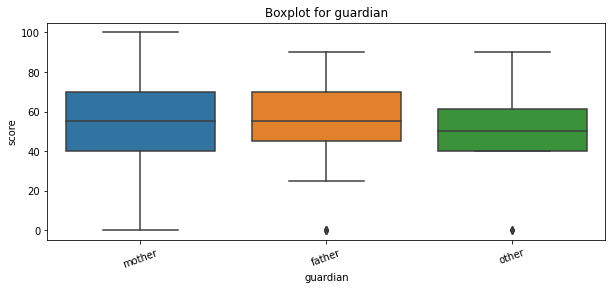

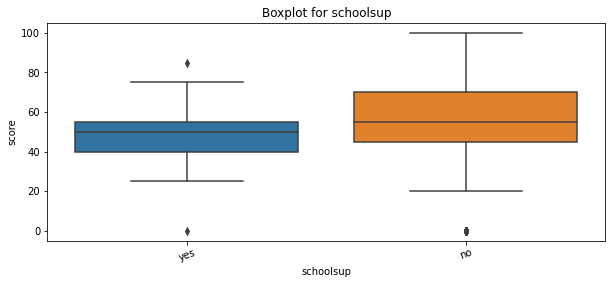

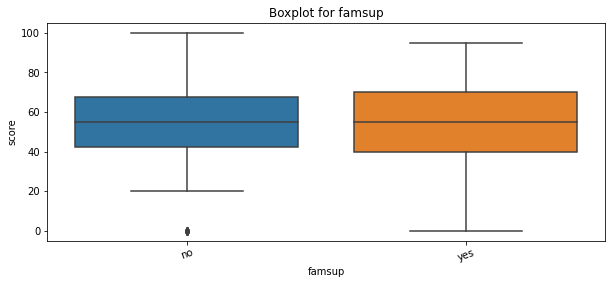

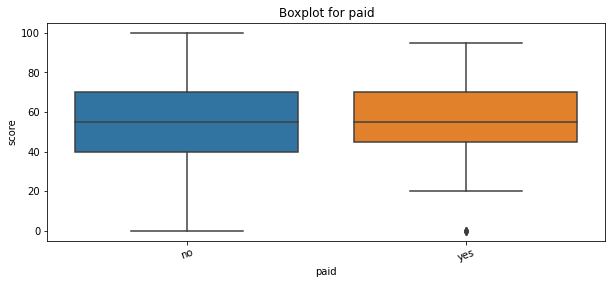

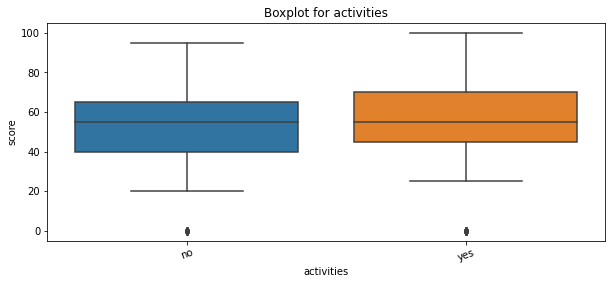

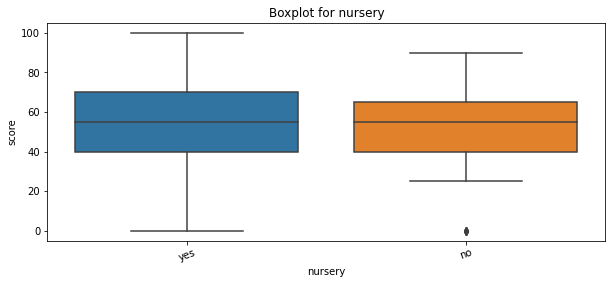

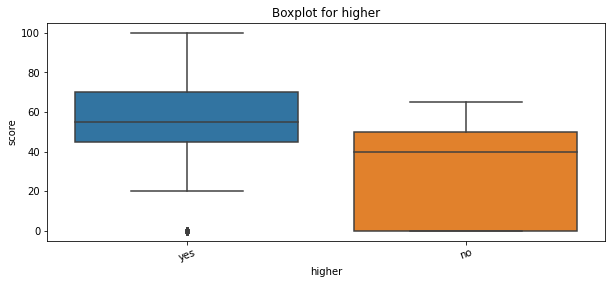

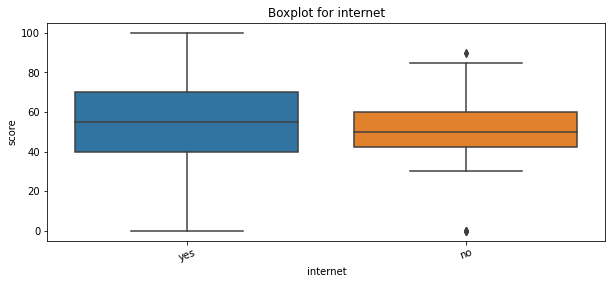

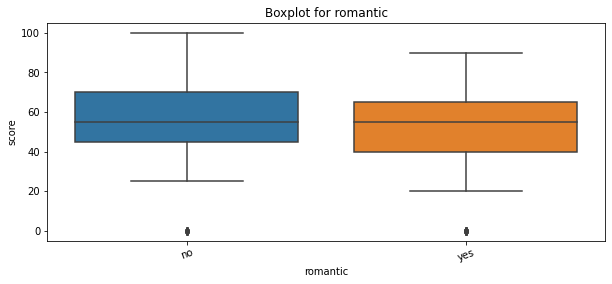

In [138]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (10, 4))
    sns.boxplot(x=column, y='score', 
                data=stud.loc[stud.loc[:, column].isin(stud.loc[:, column]
                .value_counts().index[:10])],ax=ax)
    plt.xticks(rotation=20)
    ax.set_title('Boxplot for ' + column)
    plt.show()

    
for col in stud_non_numeric:
    get_boxplot(col)

По графикам похоже, что параметры address, Mjob, Fjob, schoolsup, higher могут влиять на оценку по математике. Однако графики являются лишь вспомогательным инструментом, настоящую значимость различий посмотрим с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения score по различным параметрам неразличимы:

In [139]:
def get_stat_dif(column):
    cols = stud.loc[:, column].value_counts().index[:5]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud.loc[stud.loc[:, column] == comb[0], 'score'], 
                stud.loc[stud.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [140]:
for col in stud_non_numeric:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


Похоже данные значимые колонки появились при удалении пустых значений из столбца score. Посмотрим, что произойдет, если мы заменим пустые значения случайным образом.

In [141]:

stud_new = stud.copy()
for col in stud_non_numeric:
    mask = stud_new[col].isna()
    #считаем статистику распределения значений
    p = stud_new[col].value_counts()/len(stud_new[col].dropna())
    #заполняем пропуски с вероятностью p
    stud_new.loc[mask,col]=np.random.choice(p.index.to_list(),
                                            size = mask.sum(), p=p.to_list()) 

Посмотрим с помощью теста Стьюдента.

In [142]:
def get_stat_dif(column):
    cols = stud_new .loc[:, column].value_counts().index[:5]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud_new .loc[stud.loc[:, column] == comb[0], 'score'], 
                stud_new .loc[stud.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [143]:
for col in stud_non_numeric:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


Судя по всему данных мы не испортили и в данном случае такая замена возможна.

**ВЫВОДЫ**

Итак, в результате EDA для анализа влияния условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике были получены следующие выводы:

В данных присутствуют пропущенные значения.
В некоторых столбцах были найдены нетипичные значения переменных.
Положительная корреляция параметра score и столбцов Medu, Fedu, famrel может говорить о том, что образование родителей и семейные отношения оказывают положительное влияние на успеваемость ребенка по математике. Чем лучше образование родителей и гармоничнее отношение в семье, тем выше значение балла по математике.
Исходя из анализа, предлагается использовать в дальнейшем для построения модели следующие данные age, Medu и Fedu (с объединением в общий признак), traveltime, studytime, failures, famrel, freetime, goout, health, absences, address, Mjob, higher, romantic. И присмотрется к данным в столбцах Fjob, schoolsup.  
Так как количество признаков в некоторых столбцах имеет мало уникальных значений, можно разбить и заменить значения бинарными признаками.